<a href="https://colab.research.google.com/github/Jdasanja/mirrored-dataset/blob/main/Project3_UnsupervisedLearning_07_06_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import sklearn as sk
import seaborn as sns

In [2]:
!pip install pyreadstat

Step:1 Load your Data

In [3]:
import pandas as pd

# Load the dataset
url = 'https://github.com/Jdasanja/mirrored-dataset/blob/main/fram_heart_study.csv?raw=true'
df = pd.read_csv(url)

# Add a unique identifier column
df['patient_id'] = range(1, len(df) + 1)

# Set 'patient_id' as the index
df.set_index('patient_id', inplace=True)

print(df.head(5))

            male  age  education  currentSmoker  cigsPerDay  BPMeds  \
patient_id                                                            
1              1   39        4.0              0         0.0     0.0   
2              0   46        2.0              0         0.0     0.0   
3              1   48        1.0              1        20.0     0.0   
4              0   61        3.0              1        30.0     0.0   
5              0   46        3.0              1        23.0     0.0   

            prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP  \
patient_id                                                                   
1                         0             0         0    195.0  106.0   70.0   
2                         0             0         0    250.0  121.0   81.0   
3                         0             0         0    245.0  127.5   80.0   
4                         0             1         0    225.0  150.0   95.0   
5                         0       

In [4]:
from sklearn.utils import resample
target_column = 'TenYearCHD'
# Upsampling the minority class
data_majority = df[df[target_column] == 0]
data_minority = df[df[target_column] == 1]
data_minority_upsampled = resample(data_minority, replace=True, n_samples=len(data_majority), random_state=123)
df_upsampled = pd.concat([data_majority, data_minority_upsampled])

In [5]:
from sklearn.model_selection import train_test_split
# Define the features and target
# Drop the unique identifier and the target column from features
X = df_upsampled.drop(columns=['TenYearCHD'])

# Separate the target
y = df_upsampled['TenYearCHD']

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Now, X_train and X_test contain only relevant feature columns
# y_train and y_test contain only the target variable

In [6]:
from sklearn.impute import SimpleImputer

# Handling missing values using imputation strategies
mean_imputer = SimpleImputer(strategy='mean')
mean_cols = ['heartRate']
X_train[mean_cols] = mean_imputer.fit_transform(X_train[mean_cols])
X_test[mean_cols] = mean_imputer.transform(X_test[mean_cols])

median_imputer = SimpleImputer(strategy='median')
median_cols = ['education', 'cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'glucose']
X_train[median_cols] = median_imputer.fit_transform(X_train[median_cols])
X_test[median_cols] = median_imputer.transform(X_test[median_cols])

# Verify no missing values are present
print(X_train.isnull().sum())
print(X_test.isnull().sum())

# Handling outliers using the IQR method
def handle_outliers_with_IQR(X_train, column):
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_train[column] = X_train[column].clip(lower=lower_bound, upper=upper_bound)

continuous_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
for col in continuous_cols:
    handle_outliers_with_IQR(X_train, col)

# Handling outliers using the IQR method
def handle_outliers_with_IQR(X_test, column):
    Q1 = X_test[column].quantile(0.25)
    Q3 = X_test[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_test[column] = X_test[column].clip(lower=lower_bound, upper=upper_bound)

continuous_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
for col in continuous_cols:
    handle_outliers_with_IQR(X_test, col)

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
dtype: int64
male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
dtype: int64


In [7]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import OneHotEncoder

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.columns] = np.log1p(X_copy[self.columns])
        return X_copy
# Define the columns to apply logarithmic transformation
log_transform_columns = ['sysBP', 'diaBP']

# Define the preprocessing pipeline
ct = ColumnTransformer(
    transformers=[
        ("log_transform", LogTransformer(log_transform_columns), log_transform_columns),
        ("scaling", StandardScaler(), ['age','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate','glucose']),
        ("onehot", OneHotEncoder(sparse_output=False), ['BPMeds', 'education', 'male','diabetes','currentSmoker','prevalentStroke','prevalentHyp'])
    ],
    remainder='drop'  # drop all other columns not specified
)

# Apply the transformations
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

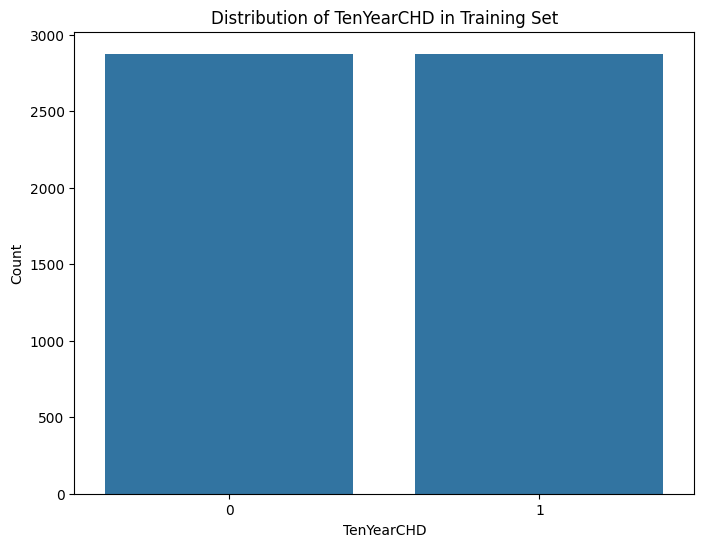

In [8]:
# Checking if the data is imbalanced

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target attribute
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title('Distribution of TenYearCHD in Training Set')
plt.xlabel('TenYearCHD')
plt.ylabel('Count')
plt.show()

Step 2: PCA for feature selection
<br>- Additional Step: Using UMAP for feature selection

In [9]:
from sklearn.decomposition import PCA

# keep all the principal components of the data
pca1 = PCA()
# fit PCA model to data
pca1.fit(X_train)

print('-'*20 + 'Explained variance ratio' + '-'*20)
print(pca1.explained_variance_ratio_)

--------------------Explained variance ratio--------------------
[2.58634242e-01 1.45003088e-01 9.94082637e-02 9.27876577e-02
 8.97025202e-02 8.21843534e-02 6.82375382e-02 3.82322815e-02
 3.06195677e-02 2.18343156e-02 1.84289643e-02 1.49717092e-02
 1.31580195e-02 1.13070459e-02 7.09614417e-03 6.05909639e-03
 2.29261848e-03 3.36736544e-05 8.90090242e-06 2.14302976e-33
 2.14302976e-33 2.14302976e-33 2.14302976e-33 2.14302976e-33
 2.14302976e-33 2.14302976e-33]


In [10]:
pca95 = PCA(n_components=0.95)
X_train_pca95 = pca95.fit(X_train)

print('-'*20 + 'Explained variance ratio' + '-'*20)
print(X_train_pca95.explained_variance_ratio_)

--------------------Explained variance ratio--------------------
[0.25863424 0.14500309 0.09940826 0.09278766 0.08970252 0.08218435
 0.06823754 0.03823228 0.03061957 0.02183432 0.01842896 0.01497171]


In [11]:
X_train_pca = pca95.fit_transform(X_train)
X_test_pca = pca95.transform(X_test)

Random Forrest Classifier with PCA

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,precision_score, recall_score
import matplotlib.pyplot as plt

model2 = RandomForestClassifier(n_estimators=100, random_state=42,max_depth=10).fit(X_train_pca, y_train)

print("Accuracy on training set: {:.2f}".format(model2.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.2f}".format(model2.score(X_test_pca, y_test)))

Accuracy on training set: 0.95
Accuracy on test set: 0.88


Random Forrest Classifier without PCA


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,precision_score, recall_score
import matplotlib.pyplot as plt

model2 = RandomForestClassifier(n_estimators=100, random_state=42,max_depth=10).fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(model2.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(model2.score(X_test, y_test)))

Accuracy on training set: 0.94
Accuracy on test set: 0.88


Step 3: Apply 3-types of clustering on your data and visualize the output of each both with and without PCA run on it first. Calculate both ARI and Silhouette Coefficient for all six of the combinations.

K-Means Clustering without PCA

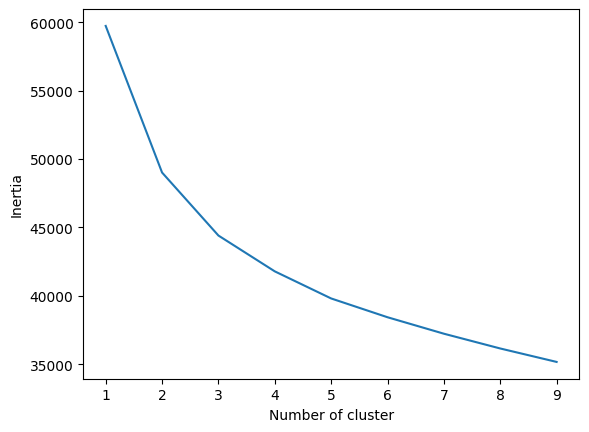

In [14]:
from sklearn.cluster import KMeans
inertiaVals = {}

for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(X_train)
    inertiaVals[k] = kmeansTmp.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

In [15]:
!pip install mglearn

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import matplotlib.pyplot as plt
import mglearn

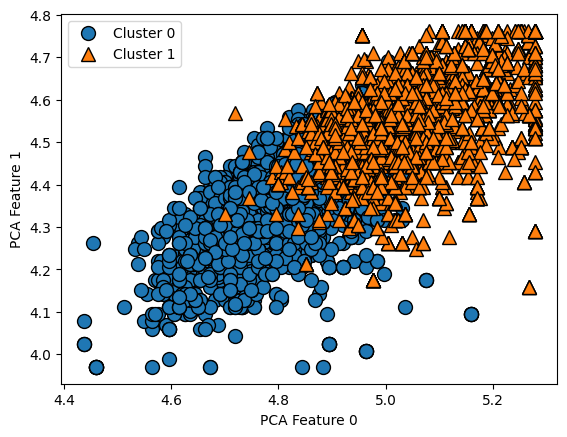

Adjusted Rand Index (ARI): 0.054500787344182615
Silhouette Coefficient: 0.1733815834114224


In [17]:
# Build the clustering model with more n_init
kmeans = KMeans(n_clusters=2, n_init=20, random_state=42)
kmeans.fit(X_train)
assignments = kmeans.labels_

# Plot the clustering result
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], assignments)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("PCA Feature 0")
plt.ylabel("PCA Feature 1")
plt.show()

# Calculate ARI
ari = adjusted_rand_score(y_train, assignments)
print(f"Adjusted Rand Index (ARI): {ari}")

# Calculate Silhouette Coefficient
silhouette_coeff = silhouette_score(X_train, assignments)
print(f"Silhouette Coefficient: {silhouette_coeff}")

K-Means Clustering with PCA

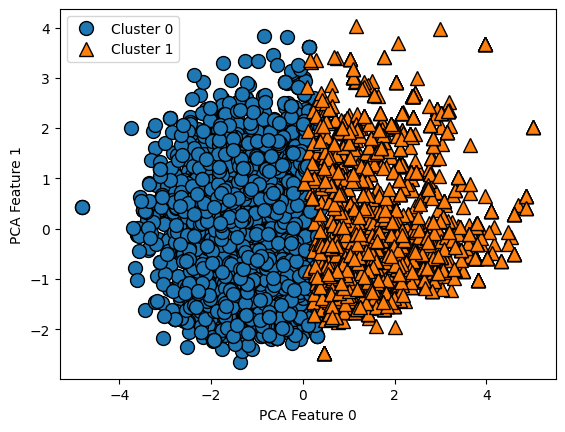

Adjusted Rand Index (ARI): 0.054338305284008626
Silhouette Coefficient: 0.17939438257781512


In [18]:
# Build the clustering model with more n_init
kmeans = KMeans(n_clusters=2, n_init=20, random_state=42)
kmeans.fit(X_train_pca)
assignments = kmeans.labels_

# Plot the clustering result
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], assignments)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("PCA Feature 0")
plt.ylabel("PCA Feature 1")
plt.show()

# Calculate ARI
ari = adjusted_rand_score(y_train, assignments)
print(f"Adjusted Rand Index (ARI): {ari}")

# Calculate Silhouette Coefficient
silhouette_coeff = silhouette_score(X_train_pca, assignments)
print(f"Silhouette Coefficient: {silhouette_coeff}")

Extra Step: Kmeans Clustering with UMAP

In [19]:
pip install umap-learn

In [20]:
import umap
manifold = umap.UMAP().fit(X_train, y_train)
X_reduced = manifold.transform(X_train)

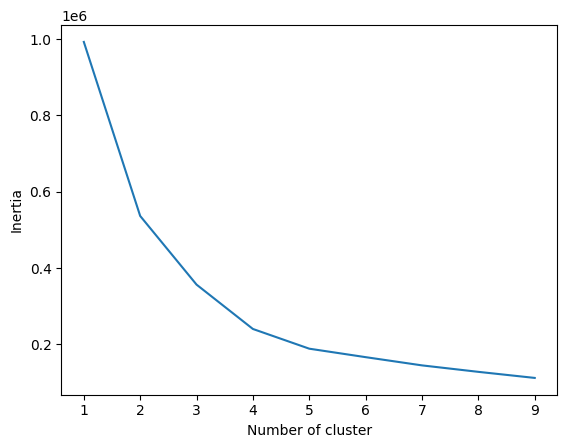

In [21]:
from sklearn.cluster import KMeans
inertiaVals = {}

for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(X_reduced)
    inertiaVals[k] = kmeansTmp.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

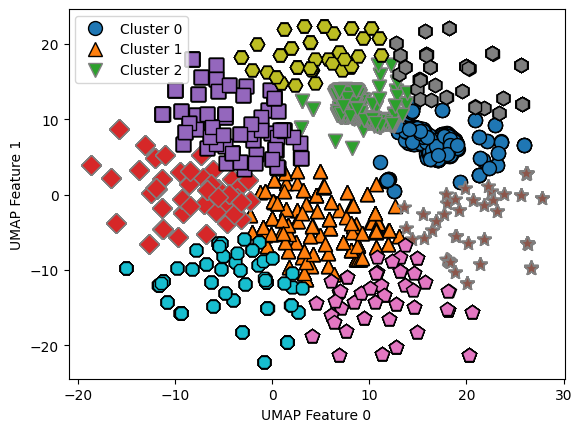

Adjusted Rand Index (ARI): 0.2577751503072939
Silhouette Coefficient: 0.5064749121665955


In [22]:
# Build the clustering model with more n_init
kmeans = KMeans(n_clusters=10, n_init=50, random_state=42)
kmeans.fit(X_reduced)
assignments = kmeans.labels_

# Plot the clustering result
mglearn.discrete_scatter(X_reduced[:, 0], X_reduced[:, 1], assignments)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("UMAP Feature 0")
plt.ylabel("UMAP Feature 1")
plt.show()

# Calculate ARI
ari = adjusted_rand_score(y_train, assignments)
print(f"Adjusted Rand Index (ARI): {ari}")

# Calculate Silhouette Coefficient
silhouette_coeff = silhouette_score(X_reduced, assignments)
print(f"Silhouette Coefficient: {silhouette_coeff}")

Density Based Scanning (DBSCAN) Clustering:No PCA

In [23]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_train)
distances, indices = neighbors_fit.kneighbors(X_train)

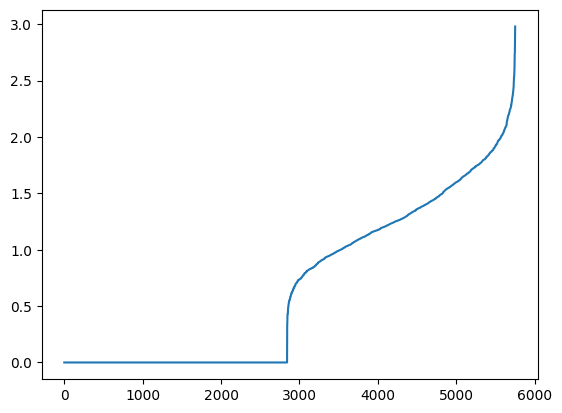

In [24]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Number of clusters: 429
Silhouette Coefficient: 0.08795073559874272
Adjusted Rand Index: 0.33299348102783


<ipython-input-25-f06814f49a12>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels)).colors


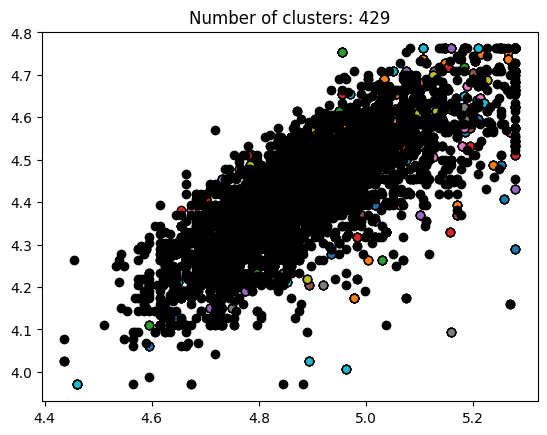

In [25]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_reduced and true_labels are your data and ground truth labels
db = DBSCAN(eps=0.8, min_samples=4).fit(X_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print(f'Number of clusters: {n_clusters_}')

# Silhouette Coefficient calculation (excluding noise points if present)
if n_clusters_ > 1:
    silhouette_avg = silhouette_score(X_train, labels)
    print(f'Silhouette Coefficient: {silhouette_avg}')
else:
    print("Silhouette Coefficient: Cannot be calculated for a single cluster")

# Adjusted Rand Index calculation (requires ground truth labels)
# Replace 'true_labels' with your actual ground truth labels
true_labels = y_train  # your ground truth labels here
ari = adjusted_rand_score(true_labels, labels)
print(f'Adjusted Rand Index: {ari}')

# Plot result
unique_labels = set(labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels)).colors

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X_train[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)

    xy = X_train[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)

plt.title('Number of clusters: %d' % n_clusters_)
plt.show()

DBSCAN Clustering With PCA

In [26]:
from sklearn.neighbors import NearestNeighbors
neighbors_fit_pca = NearestNeighbors(n_neighbors=4)
neighbors_fit_pca = neighbors.fit(X_train_pca)
distances_pca, indices = neighbors_fit_pca.kneighbors(X_train_pca)

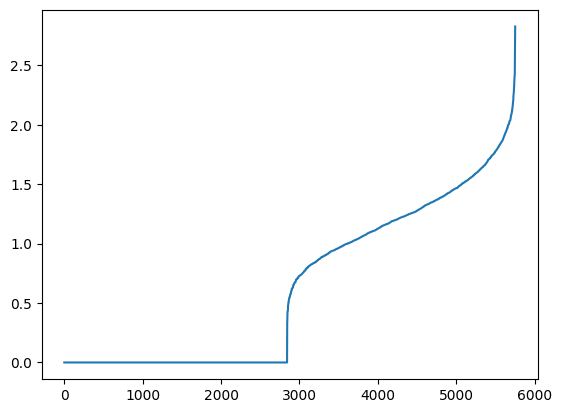

In [27]:
distances_pca = np.sort(distances_pca, axis=0)
distances_pca= distances_pca[:,1]
plt.plot(distances_pca)

Number of clusters: 430
Silhouette Coefficient: 0.08038990141479757
Adjusted Rand Index: 0.33242422602245036


<ipython-input-28-015c9cecdb9a>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels)).colors


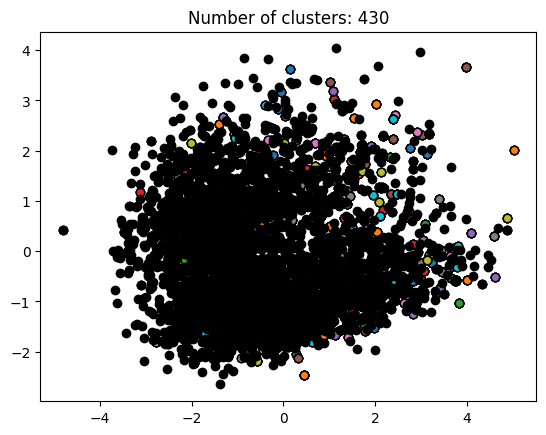

In [28]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_reduced and true_labels are your data and ground truth labels
db = DBSCAN(eps=0.8, min_samples=4).fit(X_train_pca)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print(f'Number of clusters: {n_clusters_}')

# Silhouette Coefficient calculation (excluding noise points if present)
if n_clusters_ > 1:
    silhouette_avg = silhouette_score(X_train_pca, labels)
    print(f'Silhouette Coefficient: {silhouette_avg}')
else:
    print("Silhouette Coefficient: Cannot be calculated for a single cluster")

# Adjusted Rand Index calculation (requires ground truth labels)
# Replace 'true_labels' with your actual ground truth labels
true_labels = y_train  # your ground truth labels here
ari = adjusted_rand_score(true_labels, labels)
print(f'Adjusted Rand Index: {ari}')

# Plot result
unique_labels = set(labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels)).colors

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X_train_pca[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)

    xy = X_train_pca[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)

plt.title('Number of clusters: %d' % n_clusters_)
plt.show()

DBSCAN Clustering with UMAP

In [29]:
from sklearn.neighbors import NearestNeighbors
neighbors_fit_reduced = NearestNeighbors(n_neighbors=4)
neighbors_fit_reduced = neighbors.fit(X_reduced)
distances_reduced, indices = neighbors_fit_reduced.kneighbors(X_reduced)

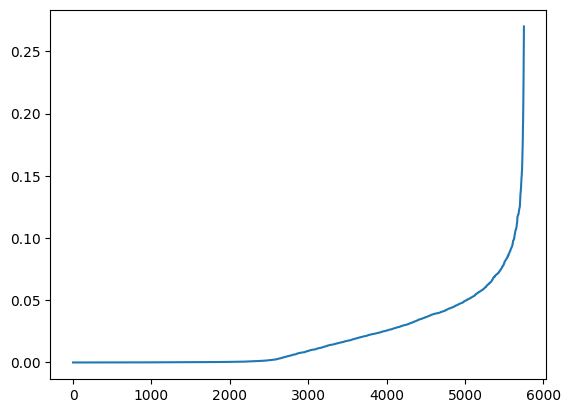

In [30]:
distances_reduced = np.sort(distances_reduced, axis=0)
distances_reduced = distances_reduced[:,1]
plt.plot(distances_reduced)

Number of clusters: 330
Silhouette Coefficient: 0.23279975354671478
Adjusted Rand Index: 0.4863071479079496


<ipython-input-31-34b24e7d4523>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels)).colors


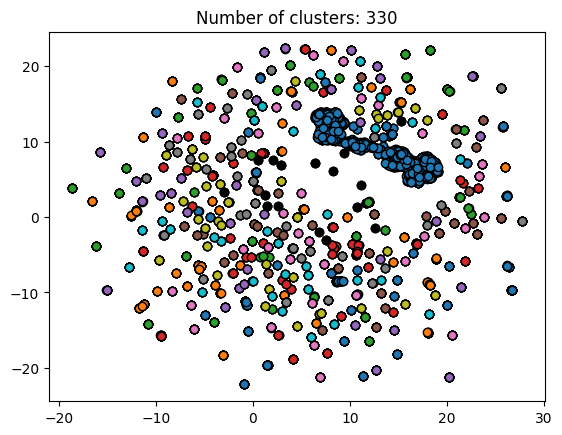

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_reduced and true_labels are your data and ground truth labels
db = DBSCAN(eps=0.8, min_samples=4).fit(X_reduced)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print(f'Number of clusters: {n_clusters_}')

# Silhouette Coefficient calculation (excluding noise points if present)
if n_clusters_ > 1:
    silhouette_avg = silhouette_score(X_reduced, labels)
    print(f'Silhouette Coefficient: {silhouette_avg}')
else:
    print("Silhouette Coefficient: Cannot be calculated for a single cluster")

# Adjusted Rand Index calculation (requires ground truth labels)
# Replace 'true_labels' with your actual ground truth labels
true_labels = y_train  # your ground truth labels here
ari = adjusted_rand_score(true_labels, labels)
print(f'Adjusted Rand Index: {ari}')

# Plot result
unique_labels = set(labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels)).colors

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X_reduced[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)

    xy = X_reduced[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)

plt.title('Number of clusters: %d' % n_clusters_)
plt.show()

Aggolmerate/Hierarchical Clustering: No PCA

<Figure size 600x600 with 0 Axes>

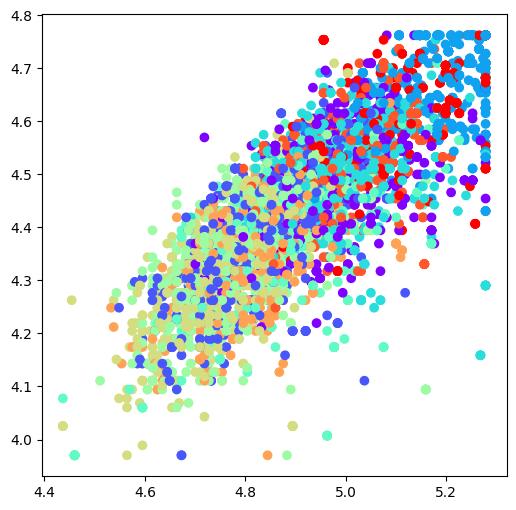

Silhouette Coefficient: 0.054119684607955874
Adjusted Rand Index: 0.023713867805330007


In [32]:
from sklearn.cluster import AgglomerativeClustering
ac2 = AgglomerativeClustering(n_clusters = 10, metric = 'euclidean', linkage = 'ward')

# Visualizing the clustering
plt.figure(figsize =(6, 6))
# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(X_train[:, 0], X_train[:, 1],  # Access columns of NumPy array using integer indexing
           c = ac2.fit_predict(X_train), cmap ='rainbow')
plt.show()
plt.show()

# Calculate Silhouette Coefficient and Adjusted Rand Index
silhouette_avg = silhouette_score(X_train, ac2.fit_predict(X_train))
# Calculate ARI score
ari_score = adjusted_rand_score(y_train, ac2.fit_predict(X_train))

# Print the ARI score
print(f'Silhouette Coefficient: {silhouette_avg}')
print(f'Adjusted Rand Index: {ari_score}')

Aggolmerate/Hierarchical Clustering: PCA

<Figure size 600x600 with 0 Axes>

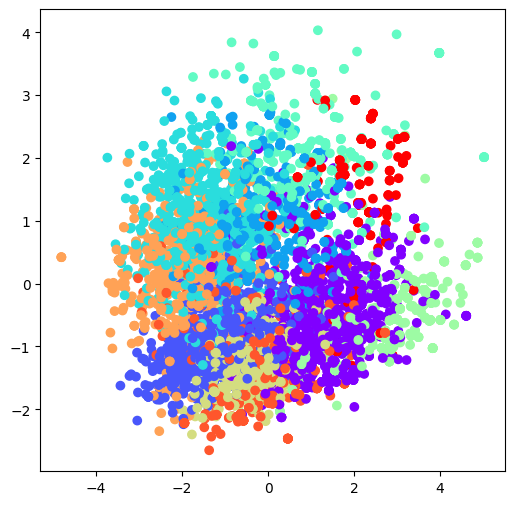

Silhouette Coefficient: 0.04994864193389289
Adjusted Rand Index: 0.018853903807914622


In [33]:
from sklearn.cluster import AgglomerativeClustering
ac3 = AgglomerativeClustering(n_clusters = 10, metric = 'euclidean', linkage = 'ward')

# Visualizing the clustering
plt.figure(figsize =(6, 6))
# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],  # Access columns of NumPy array using integer indexing
           c = ac3.fit_predict(X_train_pca), cmap ='rainbow')
plt.show()
plt.show()

# Calculate Silhouette Coefficient and Adjusted Rand Index
silhouette_avg = silhouette_score(X_train_pca, ac3.fit_predict(X_train_pca))
# Calculate ARI score
ari_score = adjusted_rand_score(y_train, ac3.fit_predict(X_train_pca))

# Print the ARI score
print(f'Silhouette Coefficient: {silhouette_avg}')
print(f'Adjusted Rand Index: {ari_score}')

Aggolmerate/Hierarchical Clustering: UMAP

<Figure size 600x600 with 0 Axes>

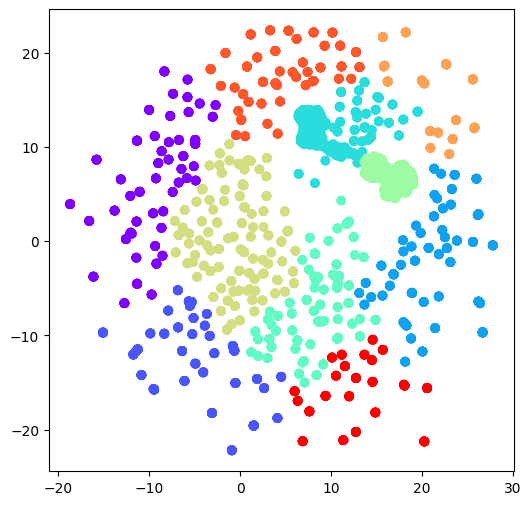

Silhouette Coefficient: 0.4623921513557434
Adjusted Rand Index: 0.2766173751346314


In [34]:
from sklearn.cluster import AgglomerativeClustering
ac4 = AgglomerativeClustering(n_clusters = 10, metric = 'euclidean', linkage = 'ward')

# Visualizing the clustering
plt.figure(figsize =(6, 6))
# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],  # Access columns of NumPy array using integer indexing
           c = ac4.fit_predict(X_reduced), cmap ='rainbow')
plt.show()
plt.show()

# Calculate Silhouette Coefficient and Adjusted Rand Index
silhouette_avg = silhouette_score(X_reduced, ac4.fit_predict(X_reduced))
# Calculate ARI score
ari_score = adjusted_rand_score(y_train, ac4.fit_predict(X_reduced))

# Print the ARI score
print(f'Silhouette Coefficient: {silhouette_avg}')
print(f'Adjusted Rand Index: {ari_score}')